<a href="https://colab.research.google.com/github/Kiran98780/NLP_Assignment2/blob/main/Copy_of_Copy_of_BERT_for_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning BERT for Sentiment Analysis
[![Portfolio](https://img.shields.io/badge/Portfolio-chriskhanhtran.github.io-blue?logo=GitHub)](https://chriskhanhtran.github.io/)

# A - Introduction

In recent years the NLP community has seen many breakthoughs in Natural Language Processing, especially the shift to transfer learning. Models like ELMo, fast.ai's ULMFiT, Transformer and OpenAI's GPT have allowed researchers to achieves state-of-the-art results on multiple benchmarks and provided the community with large pre-trained models with high performance. This shift in NLP is seen as NLP's ImageNet moment, a shift in computer vision a few year ago when lower layers of deep learning networks with million of parameters trained on a specific task can be reused and fine-tuned for other tasks, rather than training new networks from scratch.

One of the most biggest milestones in the evolution of NLP recently is the release of Google's BERT, which is described as the beginning of a new era in NLP. In this notebook I'll use the HuggingFace's `transformers` library to fine-tune pretrained BERT model for a classification task. Then I will compare the BERT's performance  with a baseline model, in which I use a TF-IDF vectorizer and a Naive Bayes classifier. The `transformers` library help us quickly and efficiently fine-tune the state-of-the-art BERT model and yield an accuracy rate **10%** higher than the baseline model.

**Reference**:

To understand **Transformer** (the architecture which BERT is built on) and learn how to implement BERT, I highly recommend reading the following sources:

- [The Illustrated BERT, ELMo, and co.](http://jalammar.github.io/illustrated-bert/): A very clear and well-written guide to understand BERT.
- [The documentation of the `transformers` library](https://huggingface.co/transformers/v2.2.0/index.html)
- [BERT Fine-Tuning Tutorial with PyTorch](http://mccormickml.com/2019/07/22/BERT-fine-tuning/) by [Chris McCormick](http://mccormickml.com/): A very detailed tutorial showing how to use BERT with the HuggingFace PyTorch library.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [ ]:
%ls

 10-bert.ipynb
 BERT_for_Sentiment_Analysis.ipynb
 Concatenating_replies.ipynb
'Copy of 10-bert.ipynb'
 Copy_of_BERT_for_Sentiment_Analysis.ipynb
'Copy of MaskRCNN Custom Trial 1.ipynb'
 ImageClassifierCNN.ipynb
'MaskRCNN Custom Trial 1.ipynb'
'MaskRCNN Custom Trial2.ipynb'
'MaskRCNN NET Surface Detection.ipynb'
'MaskRCNN Trial1.ipynb'
'sampled_netflow (1).csv'
 sampled_netflow.csv
'sampler_(1)_Copy1 (1)-Copy2.ipynb'
 test_data.csv
 TestGPU.ipynb
 training_data.csv
 train_shapes.ipynb
 Untitled
 Untitled0.ipynb
'Untitled (1)'
 Untitled1.ipynb
 Untitled2.ipynb
 Untitled3.ipynb
 Untitled4.ipynb
'Working - MaskRCNN Microcontroller Detection.ipynb'


In [ ]:
%cd /content/drive/My Drive/NLP_data

/content/drive/My Drive/NLP_data


In [ ]:
%ls

dev.baseline1.json       dev.label.json    sstcls_3.dat     train.data.jsonl
dev.baseline_bert2.json  firstthree.jsonl  sstcls_6.dat     train.label.json
dev.data.jsonl           sstcls_0.dat      test.data.jsonl


# B - Setup

## 1. Load Essential Libraries

In [ ]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## 2. Dataset

### 2.1. Download Dataset

### 2.2. Load Train Data
The train data has 2 files, each containing 1700 complaining/non-complaining tweets. Every tweets in the data contains at least a hashtag of an airline.

We will load the train data and label it. Because we use only the text data to classify, we will drop unimportant columns and only keep `id`, `tweet` and `label` columns.

In [ ]:
import pandas as pd
import json
from sklearn import preprocessing
import re
def get_replies(df):
    for index, row in df.iterrows():
        x = re.search(r'\d+', str(row['in_reply_to_status_id_str'])) #check if the string matches a number 
        if x:
            big_list.append(row["tweet"]) #append the reply tweets in a big_list and return the list
        else:
            big_list = []
    return big_list,len(big_list)

pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.min_rows', 100)
pd.set_option('display.max_rows', 500)

with open("train.data.jsonl", 'r', encoding='utf-8') as train_data_file:
  list_of_rlists = []
  chunks = []
  num_replies = []
  for line in train_data_file:
    train_Data_list = json.loads(line)
    df = pd.DataFrame.from_dict(train_Data_list)
    df = df[["id_str","in_reply_to_status_id_str","text", "user","favorited","in_reply_to_user_id_str"]]
    df.rename(columns={'id_str': 'id'}, inplace=True)
    df.rename(columns={'text': 'tweet'}, inplace=True)
    replies_list,len_reply_list = get_replies(df) #reply list for a single source tweet
    chunks.append(df)
    list_of_rlists.append(replies_list)
    num_replies.append(len_reply_list)
    # print("The output of list_of_rlists in every iteration=",list_of_rlists,"\n",len(list_of_rlists))
  dfs1 = pd.concat(chunks)
train_data_file.close()
#print(dfs1)
print("The len of list of list of replies=", len(list_of_rlists))


with open("train.label.json") as train_label_file:
    train_label_json_file = json.load(train_label_file)
    df_train_label = pd.DataFrame(list(train_label_json_file.items()),columns = ['id', 'label'])
train_label_file.close()

#print(df_train_label)
#print(df_train_label.groupby('label').size())
# non - rumour
# 3058
# rumour
# 1583

#check the id and if it is present in rumours/non-rumours labels, then add it to the row of that dataframe (check from the labels dataframe)
df_final1 = pd.merge(dfs1, df_train_label, how='left', left_on='id', right_on='id')
df_final2 = pd.merge(dfs1, df_train_label, how='inner', left_on='id', right_on='id')

# print(df_final1)
print(df_final1.shape) #(81120, 7)

# print(df_final2)
print(df_final2.shape) #(4641, 7)


#only text and label - drop columns from old one and store in new one 
Corpus = df_final2.drop(["in_reply_to_status_id_str","user","favorited","in_reply_to_user_id_str"], axis=1)
le = preprocessing.LabelEncoder()
Corpus['label'] = le.fit_transform(Corpus['label'])
Corpus["all_replies"] = list_of_rlists #has a list of replies 
Corpus["num_replies"] = num_replies
print(Corpus.head(10))
print(Corpus.dtypes)
print(Corpus.shape)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


The len of list of list of replies= 4641
(81120, 7)
(4641, 7)
                   id                                              tweet  label                                        all_replies  num_replies
0  552800070199148544  How to respond to the murderous attack on Char...      0  [@Heresy_Corner @KrustyAllslopp \nJews label a...           28
1  544388259359387648  You can't condemn an entire race, nation or re...      0  [@LozzaCopland How many times are we going to ...           29
2  552805970536333314  Attempts to extend blame for this to all Musli...      0  [@iyad_elbaghdadi @Axxeen when will we see mas...           15
3  525071376084791297  Rest in Peace, Cpl. Nathan Cirillo. Killed tod...      1  [@GigiGraciette hot guy, @Corey_Frizzell hey f...           13
4  498355319979143168  People DEBATING whether #MikeBrown shoplifted ...      0  [@kurbster3 @VABVOX @commonman80 yeah and shoo...           12
5  553591259672379392  Update - PA: gunman holding hostages in #Paris...  

In [ ]:
with open("dev.data.jsonl", 'r', encoding='utf-8') as dev_data_file:
  chunks = []
  list_of_rlists = []
  num_replies = []
  for line in dev_data_file:
    dev_Data_list = json.loads(line)
    df = pd.DataFrame.from_dict(dev_Data_list)
    df = df[["id_str","in_reply_to_status_id_str","text", "user","favorited","in_reply_to_user_id_str"]]
    df.rename(columns={'id_str': 'id'}, inplace=True)
    df.rename(columns={'text': 'tweet'}, inplace=True)
    replies_list,len_reply_list = get_replies(df)
    chunks.append(df)
    num_replies.append(len_reply_list)
    list_of_rlists.append(replies_list)
  dfs_dev = pd.concat(chunks)
dev_data_file.close()
#print(dfs_dev)

with open("dev.label.json") as dev_label_file:
    dev_label_json_file = json.load(dev_label_file)
    df_dev_label = pd.DataFrame(list(dev_label_json_file.items()),columns = ['id', 'label'])
dev_label_file.close()

#print(df_train_label)
#print(df_train_label.groupby('label').size())
# non - rumour
# 3058
# rumour
# 1583

#check the id and if it is present in rumours/non-rumours labels, then add it to the row of that dataframe (check from the labels dataframe)
df_final1_dev = pd.merge(dfs_dev, df_dev_label, how='left', left_on='id', right_on='id')
df_final2_dev = pd.merge(dfs_dev, df_dev_label, how='inner', left_on='id', right_on='id')

# print(df_final1_dev)
print(df_final1_dev.shape)
# print(df_final2_dev)
print(df_final2_dev.shape)

#only text and label - drop columns from old one and store in new one 
Corpus_dev = df_final2_dev.drop(["in_reply_to_status_id_str","user","favorited","in_reply_to_user_id_str"], axis=1)
le = preprocessing.LabelEncoder()
Corpus_dev['label'] = le.fit_transform(Corpus_dev['label'])
Corpus_dev["all_replies"] = list_of_rlists #has a list of replies 
Corpus_dev["num_replies"] = num_replies
print(Corpus_dev.head(10))
print(Corpus_dev.shape)
print(Corpus_dev.dtypes)


(10546, 7)
(580, 7)
                   id                                              tweet  label                                        all_replies  num_replies
0  553588913747808256  #BREAKING Reports: 2 brothers suspected of Cha...      1  [@USATODAY :it's unfortunate that they got wha...           10
1  524949003834634240  You are not alone today #Ottawa - we are here ...      0  [@DistressCentreO @CFRASnow interestingly - I'...            1
2  553221281181859841  Have said it before, but needs saying again: S...      0  [@kevinkrease @Max_Fisher That's a ludicrous s...           34
3  580322346508124160  Germanwings #A320 plane crashes in southern Fr...      1  [@WSJ A320 totally compromised, “@WSJ: Germanw...           13
4  544307417677189121  HOSTAGE SITUATION IN SYDNEY\nTo all our fans a...      1  [@Yeow_JX @SGAG_SG People praying is exactly w...            3
5  499363921661140993  Mound City Bar Association has agreed to donat...      0  [@Nettaaaaaaaa why would a witness 

In [ ]:
with open("test.data.jsonl", 'r', encoding='utf-8') as test_data_file:
  count_of_all_dicts = 0
  chunks = []
  list_of_rlists = []
  num_replies = []
  for line in test_data_file:
    train_Data_list = json.loads(line)
    df = pd.DataFrame.from_dict(train_Data_list)
    df = df[["id_str","in_reply_to_status_id_str","text", "user","favorited","in_reply_to_user_id_str"]]
    df.rename(columns={'id_str': 'id'}, inplace=True)
    df.rename(columns={'text': 'tweet'}, inplace=True)
    replies_list,len_reply_list = get_replies(df)
    chunks.append(df)
    num_replies.append(len_reply_list)
    list_of_rlists.append(replies_list)
  dfs1 = pd.concat(chunks)
test_data_file.close()
#print(dfs1)
finalll = dfs1[dfs1['in_reply_to_status_id_str'].isna()] #source tweets
# print(finalll)

# print(dfs1["in_reply_to_status_id_str"].isnull().sum())
# c=0
# if (dfs1["in_reply_to_status_id_str"].isnull()).all():
#     c = c+1
# print(c)
# cli = np.where(dfs1["in_reply_to_status_id_str"].isnull())
# print(cli)

#only text - drop columns from old one and store in new one 
Corpus_test = finalll.drop(["in_reply_to_status_id_str","user","favorited","in_reply_to_user_id_str"], axis=1)
Corpus_test["all_replies"] = list_of_rlists #has a list of replies 
Corpus_test["num_replies"] = num_replies

print(Corpus_test.head(10))
print(Corpus_test.shape)
print(Corpus_test.dtypes)

                   id                                              tweet                                        all_replies  num_replies
0  544382249178001408  5 people have been able to get out of Sydney c...  [@ABC @SSLATERBOARDS fucking terrorists, @ABC ...           16
0  525027317551079424  NEW: Sources: Deceased gunman who killed soldi...  [@albanyly @ABC @theviewtv @WorldNews piss off...           11
0  544273220128739329  ISIS FLAG VISIBLE AS GUNMAN SEIZES SYDNEY CAFE...  [@rConflictNews @PzFeed Its not ISIS flag its ...           39
0  499571799764770816  People of #Ferguson: Stop #attacking our brave...  [@NuaEabhrac @GOPTeens yes, @keirhaug haha it'...           34
0  552844104418091008  #CharlieHebdo editor, assassinated today, said...  [@PeterPannier I'd be curious to know more abo...           46
0  524977651476623360  Soldier shot at War Memorial in Ottawa has die...  [Very sad news “@globeandmail: Soldier shot at...           15
0  544514988078280704  Gunman in #Sydneys

We will randomly split the entire training data into two sets: a train set with 90% of the data and a validation set with 10% of the data. We will perform hyperparameter tuning using cross-validation on the train set and use the validation set to compare models.

In [ ]:
X = Corpus.tweet.values
y = Corpus.label.values
X_train = Corpus.tweet.values + Corpus.all_replies.values
X_val = Corpus_dev.tweet.values
y_train = Corpus.label.values
y_val = Corpus_dev.label.values
X_test = Corpus_test.tweet.values

In [ ]:
print(X_train,y_train)

['How to respond to the murderous attack on Charlie Hebdo? Every newspaper in the free world should print this. http://t.co/sC2ot63F6j'
 "You can't condemn an entire race, nation or religion based on the actions of a few radicals, please keep that in mind #sydneysiege"
 'Attempts to extend blame for this to all Muslims should be treated with the same disgust as attempts to justify the attacks. #CharlieHebdo'
 ...
 "ALERT Photo: Germanwings crash plane 'lost signal at 6,800 feet,' flight radar shows - @itvnews http://t.co/m358Qc2Na1"
 'In solidarity with freedom of speech and religion and #CharlieHebdo we should all tweet #NoNegotiationswithTerrorists http://t.co/HfGQmDNWfe'
 'Prayers for #Ferguson.'] [0 0 0 ... 1 0 0]


### 2.3. Load Test Data
The test data contains 4555 examples with no label. About 300 examples are non-complaining tweets. Our task is to identify their `id` and examine manually whether our results are correct.

In [ ]:
# Load test data
test_data = Corpus_test
# Display 5 samples from the test data
test_data.sample(5)

,id,tweet,all_replies,num_replies
0,552828658747187201,BREAKING: French authorities say the two #Char...,[@MaxAbrahms No shit? After murdering 12 peopl...,5
0,525032458417610752,"Kudos to @penguins, both national anthems to b...",[@Real_ESPNLeBrun @tenorman85 @penguins this s...,6
0,500360632093646848,"After 10+ minutes, Chief Jackson abruptly ends...",[@tjholmes Still won't answer key questions. ...,7
0,553153740925304832,"Reader comment: ""Our strength comes from unity...",[@Dezeen United we stand in democratic dignity...,7
0,552841049467400192,People died today for telling jokes. #CharlieH...,[“@BRIANMBENDIS: People died today for telling...,19


## 3. Set up GPU for training

Google Colab offers free GPUs and TPUs. Since we'll be training a large neural network it's best to utilize these features.

A GPU can be added by going to the menu and selecting:

`Runtime -> Change runtime type -> Hardware accelerator: GPU`

Then we need to run the following cell to specify the GPU as the device.

In [ ]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla K80


# C - Baseline: TF-IDF + Naive Bayes Classifier

In this baseline approach, first we will use TF-IDF to vectorize our text data. Then we will use the Naive Bayes model as our classifier.

Why Naive Bayse? I have experiemented different machine learning algorithms including Random Forest, Support Vectors Machine, XGBoost and observed that Naive Bayes yields the best performance. In [Scikit-learn's guide](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) to choose the right estimator, it is also suggested that Naive Bayes should be used for text data. I also tried using SVD to reduce dimensionality; however, it did not yield a better performance.

## 1. Data Preparation

### 1.1. Preprocessing

In the bag-of-words model, a text is represented as the bag of its words, disregarding grammar and word order. Therefore, we will want to remove stop words, punctuations and characters that don't contribute much to the sentence's meaning.

In [ ]:
import nltk
# Uncomment to download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### 1.2. TF-IDF Vectorizer

In information retrieval, **TF-IDF**, short for **term frequency–inverse document frequency**, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. We will use TF-IDF to vectorize our text data before feeding them to machine learning algorithms.

In [ ]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])
X_test_preprocessed = np.array([text_preprocessing(text) for text in X_test])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3), binary=True, smooth_idf=False) #initialise vectorisor
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)
X_test_tfidf = tf_idf.transform(X_test_preprocessed)

CPU times: user 14.9 s, sys: 1.73 s, total: 16.6 s
Wall time: 16.6 s


In [ ]:
print(tf_idf.get_feature_names())
print(X_train_tfidf.shape)
print(X_val_tfidf.shape)
print(X_test_tfidf.shape)
# print(X_val_tfidf)
print("Sparse Matrix form of test data : \n")
X_val_tfidf.todense()

['00', '00 police', '00 police release', '000', '000 000', '000 000 muslims', '000 charlie', '000 charlie hebdo', '000 circulation', '000 expected', '000 expected sell', '000 feet', '000 feet 10', '000 feet impact', '000 feet per', '000 feet started', '000 feet starting', '000 ferguson', '000 ferguson protestors', '000 http', '000 http co', '000 lashes', '000 lashes today', '000 mentions', '000 mentions illridewithyou', '000 muslim', '000 muslim australians', '000 muslims', '000 muslims australia', '000 muslims call', '000 muslims not', '000 muslims world', '000 printed', '000 printed next', '000 satirists', '000 satirists rise', '000 tweets', '000 tweets illridewithyou', '000 words', '000 words look', '000m', '000m altitude', '000m altitude http', '000m sea', '000m sea level', '00800', '00800 11', '00800 11 33', '0147', '0147 delivered', '0147 delivered nov', '01abh3ncqc', '02svsxorft', '03tiwniedk', '040pfc0if8', '0439amya3m', '04ksgeeu5i', '05pm', '05pm local', '05pm local time', '0

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

## 2. Train Naive Bayes Classifier

### 2.1. Hyperparameter Tuning

We will use cross-validation and AUC score to tune hyperparameters of our model. The function `get_auc_CV` will return the average AUC score from cross-validation.

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

The `MultinominalNB` class only have one hypterparameter - **alpha**. The code below will help us find the alpha value that gives us the highest CV AUC score.

Best alpha:  1.0


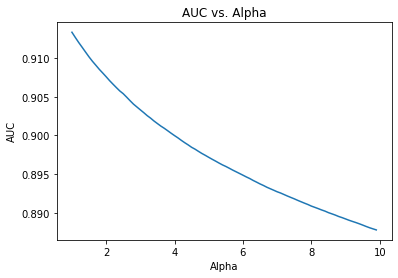

In [ ]:
from sklearn.naive_bayes import MultinomialNB

res = pd.Series([get_auc_CV(MultinomialNB(i))
                 for i in np.arange(1, 10, 0.1)],
                index=np.arange(1, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

### 2.2. Evaluation on Validation Set

To evaluate the performance of our model, we will calculate the accuracy rate and the AUC score of our model on the validation set.

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    # print("preds", preds)
    fpr, tpr, threshold = roc_curve(y_true, preds)
    # print(fpr, tpr, threshold)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

By combining TF-IDF and the Naive Bayes algorithm, we achieve the accuracy rate of **72.65%** on the validation set. This value is the baseline performance and will be used to evaluate the performance of our fine-tune BERT model. 

PROBS= [[0.68210458 0.31789542]
 [0.88374066 0.11625934]
 [0.90903687 0.09096313]
 ...
 [0.88623942 0.11376058]
 [0.73922383 0.26077617]
 [0.91364735 0.08635265]]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0
 0 1 0 0 0 0

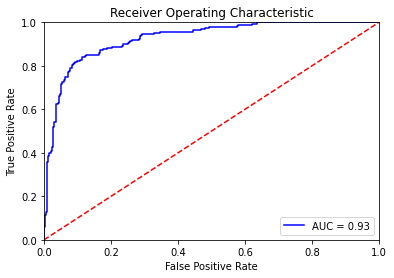

In [ ]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=1.8)
nb_model.fit(X_train_tfidf, y_train)
#Predict the response for test dataset
probs = nb_model.predict_proba(X_val_tfidf)
print("PROBS=",probs)
pred = nb_model.predict(X_val_tfidf)
print(pred)
# Evaluate the classifier
evaluate_roc(probs, y_val)

In [ ]:
pred = nb_model.predict(X_test_tfidf)
print(pred)

[1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0
 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1
 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 1 0 0 0 0 1 1 1 1 0 0 

In [ ]:
y_predicted = nb_model.predict(X_test_tfidf)
y_predicted_labels = le.inverse_transform(y_predicted) 
print(y_predicted,y_predicted_labels)

[1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0
 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1
 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 1 0 0 0 0 1 1 1 1 0 0 

In [ ]:
y_predicted = nb_model.predict(X_val_tfidf)
y_predicted_labels = le.inverse_transform(y_predicted) 
# print(y_predicted,y_predicted_labels)
print(len(y_predicted_labels))
unique, counts = np.unique(y_predicted, return_counts=True)
dict(zip(unique, counts))

580


{0: 495, 1: 85}

label
non-rumour    393
rumour        187
dtype: int64


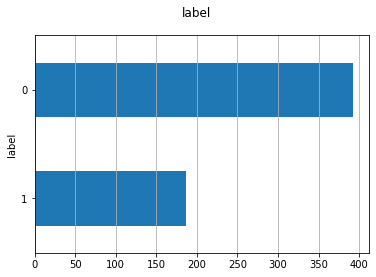

In [ ]:
print(df_dev_label.groupby('label').size())

fig, ax = plt.subplots()
fig.suptitle("label", fontsize=12)
Corpus_dev["label"].reset_index().groupby("label").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [ ]:
Corpus_pred = Corpus_dev
print(Corpus_pred.head())
Corpus_pred['label'] = y_predicted_labels
print(Corpus_pred.head())
Corpus_pred.set_index('id',inplace=True)
dictt = Corpus_pred.to_dict()['label']
print(dictt)
with open("dev.baseline1.json", "w") as outfile: 
    json.dump(dictt, outfile)

                   id                                              tweet  label                                        all_replies  num_replies
0  553588913747808256  #BREAKING Reports: 2 brothers suspected of Cha...      1  [@USATODAY :it's unfortunate that they got wha...           10
1  524949003834634240  You are not alone today #Ottawa - we are here ...      0  [@DistressCentreO @CFRASnow interestingly - I'...            1
2  553221281181859841  Have said it before, but needs saying again: S...      0  [@kevinkrease @Max_Fisher That's a ludicrous s...           34
3  580322346508124160  Germanwings #A320 plane crashes in southern Fr...      1  [@WSJ A320 totally compromised, “@WSJ: Germanw...           13
4  544307417677189121  HOSTAGE SITUATION IN SYDNEY\nTo all our fans a...      1  [@Yeow_JX @SGAG_SG People praying is exactly w...            3
                   id                                              tweet       label                                        all_replies 

In [ ]:
print(Corpus_pred.shape)


(580, 4)


# D - Fine-tuning BERT

## 1. Install the Hugging Face Library

The transformer library of Hugging Face contains PyTorch implementation of state-of-the-art NLP models including BERT (from Google), GPT (from OpenAI) ... and pre-trained model weights.

In [ ]:
!pip install transformers==2.8.0

     |████████████████████████████████| 573kB 6.9MB/s 
     |████████████████████████████████| 1.2MB 12.9MB/s 
     |████████████████████████████████| 901kB 37.4MB/s 
     |████████████████████████████████| 5.6MB 21.1MB/s 
     |████████████████████████████████| 133kB 30.9MB/s 
     |████████████████████████████████| 7.5MB 38.3MB/s 
     |████████████████████████████████| 81kB 8.9MB/s 


## 2. Tokenization and Input Formatting

Before tokenizing our text, we will perform some slight processing on our text including removing entity mentions (eg. @united) and some special character. The level of processing here is much less than in previous approachs because BERT was trained with the entire sentences.

In [ ]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
# Print sentence 0
print('Original: ', X[1])
print('Processed: ', text_preprocessing(X[1]))

Original:  You can't condemn an entire race, nation or religion based on the actions of a few radicals, please keep that in mind #sydneysiege
Processed:  You can't condemn an entire race, nation or religion based on the actions of a few radicals, please keep that in mind #sydneysiege


### 2.1. BERT Tokenizer

In order to apply the pre-trained BERT, we must use the tokenizer provided by the library. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

In addition, we are required to add special tokens to the start and end of each sentence, pad & truncate all sentences to a single constant length, and explicitly specify what are padding tokens with the "attention mask".

The `encode_plus` method of BERT tokenizer will:

(1) split our text into tokens,

(2) add the special `[CLS]` and `[SEP]` tokens, and

(3) convert these tokens into indexes of the tokenizer vocabulary,

(4) pad or truncate sentences to max length, and

(5) create attention mask.






In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
#         Set MAX_LEN = 512
# input_structure = "[CLS] Source Tweet [SEP] " + ''.join([" reply [SEP]" for reply in all_replies])

# Pad input_structure to MAX_LEN
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Before tokenizing, we need to specify the maximum length of our sentences.







In [ ]:
# # Concatenate train data and test data
# all_tweets = np.concatenate([Corpus.tweet.values, test_data.tweet.values])
# print(all_tweets)
# print(type(all_tweets))
# # Encode our concatenated data
# encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]
# print(encoded_tweets)
# # Find the maximum length
# max_len = max([len(sent) for sent in encoded_tweets])
# print('Max length: ', max_len)

['How to respond to the murderous attack on Charlie Hebdo? Every newspaper in the free world should print this. http://t.co/sC2ot63F6j'
 "You can't condemn an entire race, nation or religion based on the actions of a few radicals, please keep that in mind #sydneysiege"
 'Attempts to extend blame for this to all Muslims should be treated with the same disgust as attempts to justify the attacks. #CharlieHebdo'
 ...
 'We must confirm to our deepest regret that Germanwings Flight 4U 9525 from Barcelona to Düsseldorf has suffered an accident over the...'
 'Protestors have blocked West Florissant, a major street in St. Louis County. #Ferguson http://t.co/S15XpF4f9E'
 'Terrible news in Ottawa today. Thoughts and prayers to everyone involved #OttawaStrong http://t.co/enLyEvHhTk']
<class 'numpy.ndarray'>
[[101, 2129, 2000, 6869, 2000, 1996, 25303, 2886, 2006, 4918, 2002, 2497, 3527, 1029, 2296, 3780, 1999, 1996, 2489, 2088, 2323, 6140, 2023, 1012, 8299, 1024, 1013, 1013, 1056, 1012, 2522, 1013,

Now let's tokenize our data.

In [ ]:
# Specify `MAX_LEN`
# MAX_LEN = 64
MAX_LEN = 512

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
# print(X_train, type(X_train), len(X_train))
# print(X_val, type(X_val), len(X_val))

train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)
print(train_inputs, train_masks, val_inputs, val_masks)


Original:  How to respond to the murderous attack on Charlie Hebdo? Every newspaper in the free world should print this. http://t.co/sC2ot63F6j
Token IDs:  [101, 2129, 2000, 6869, 2000, 1996, 25303, 2886, 2006, 4918, 2002, 2497, 3527, 1029, 2296, 3780, 1999, 1996, 2489, 2088, 2323, 6140, 2023, 1012, 8299, 1024, 1013, 1013, 1056, 1012, 2522, 1013, 8040, 2475, 4140, 2575, 2509, 2546, 2575, 3501, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...
tensor([[  101,  2129,  2000,  ...,     0,     0,     0],
        [  101,  2017,  2064,  ...,     0,     0,     0],
        [  101,  4740,  2000,  ...,     0,     0,     0],
        ...,
        [  101,  9499,  6302,  ...,     0,     0,     0],
        [  101,  1999, 14657,  ...,     0,     0,     0],
        [  101, 12583,  2005,  ...,     0,     0,     0]]) tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],

### 2.2. Create PyTorch DataLoader

We will create an iterator for our dataset using the torch DataLoader class. This will help save on memory during training and boost the training speed.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
print(train_data,train_sampler,train_dataloader)
# Create the DataLoader for our validation set

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

<torch.utils.data.dataset.TensorDataset object at 0x7fe3ef824150> <torch.utils.data.sampler.RandomSampler object at 0x7fe3b73c4b90> <torch.utils.data.dataloader.DataLoader object at 0x7fe3b73c4150>


## 3. Train Our Model

### 3.1. Create BertClassifier

BERT-base consists of 12 transformer layers, each transformer layer takes in a list of token embeddings, and produces the same number of embeddings with the same hidden size (or dimensions) on the output. The output of the final transformer layer of the `[CLS]` token is used as the features of the sequence to feed a classifier.

The `transformers` library has the [`BertForSequenceClassification`](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification) class which is designed for classification tasks. However, we will create a new class so we can specify our own choice of classifiers.

Below we will create a BertClassifier class with a BERT model to extract the last hidden layer of the `[CLS]` token and a single-hidden-layer feed-forward neural network as our classifier.

In [ ]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 34 µs, sys: 15 µs, total: 49 µs
Wall time: 55.8 µs


### 3.2. Optimizer & Learning Rate Scheduler

To fine-tune our Bert Classifier, we need to create an optimizer. The authors recommend following hyper-parameters:

- Batch size: 16 or 32
- Learning rate (Adam): 5e-5, 3e-5 or 2e-5
- Number of epochs: 2, 3, 4

Huggingface provided the [run_glue.py](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109) script, an examples of implementing the `transformers` library. In the script, the AdamW optimizer is used.

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

### 3.3. Training Loop

We will train our Bert Classifier for 4 epochs. In each epoch, we will train our model and evaluate its performance on the validation set. In more details, we will:

Training:
- Unpack our data from the dataloader and load the data onto the GPU
- Zero out gradients calculated in the previous pass
- Perform a forward pass to compute logits and loss
- Perform a backward pass to compute gradients (`loss.backward()`)
- Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
- Update the model's parameters (`optimizer.step()`)
- Update the learning rate (`scheduler.step()`)

Evaluation:
- Unpack our data and load onto the GPU
- Forward pass
- Compute loss and accuracy rate over the validation set

The script below is commented with the details of our training and evaluation loop. 

In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

Now, let's start training our BertClassifier!

In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.564933   |     -      |     -     |   13.71  
   1    |   40    |   0.430684   |     -      |     -     |   13.02  
   1    |   60    |   0.446365   |     -      |     -     |   13.14  
   1    |   80    |   0.393933   |     -      |     -     |   13.17  
   1    |   100   |   0.369594   |     -      |     -     |   13.19  
   1    |   120   |   0.367115   |     -      |     -     |   13.18  
   1    |   140   |   0.359055   |     -      |     -     |   13.18  
   1    |   145   |   0.328195   |     -      |     -     |   2.76   
----------------------------------------------------------------------
   1    |    -    |   0.416709   |  0.300865  |   86.51   |   99.30  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elaps

### 3.4. Evaluation on Validation Set

The prediction step is similar to the evaluation step that we did in the training loop, but simpler. We will perform a forward pass to compute logits and apply softmax to calculate probabilities.

In [ ]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

The Bert Classifer achieves 0.90 AUC score and 82.65% accuracy rate on the validation set. This result is 10 points better than the baseline method. 

preds [0.9275543  0.0107303  0.00751242 0.3291926  0.34512845 0.04625825
 0.01050099 0.01160429 0.6446607  0.01543437 0.00911335 0.01083335
 0.8083523  0.00731014 0.20163503 0.28450048 0.04058873 0.00762165
 0.95167845 0.01200795 0.94766635 0.80827874 0.0115459  0.94973916
 0.00727148 0.39482406 0.00996935 0.08937773 0.92800903 0.2173152
 0.04561233 0.9310839  0.89681304 0.00738871 0.93850464 0.90970343
 0.8869209  0.13365425 0.58249307 0.02565785 0.925615   0.6975053
 0.9482746  0.00995186 0.9385617  0.00934868 0.9125152  0.01065626
 0.00758984 0.4666896  0.00934062 0.00734316 0.17704016 0.00798419
 0.0080313  0.9492562  0.08661438 0.00948357 0.94656545 0.01513946
 0.01136214 0.00802749 0.93786836 0.00758928 0.06491815 0.930843
 0.0145902  0.8605565  0.9202468  0.6920987  0.7786136  0.00820029
 0.9501375  0.0090043  0.00904807 0.88491493 0.00941421 0.57339406
 0.02473854 0.9505258  0.14180309 0.0508122  0.92664164 0.04124315
 0.9464199  0.29537556 0.56368095 0.9133018  0.02424015 0.00

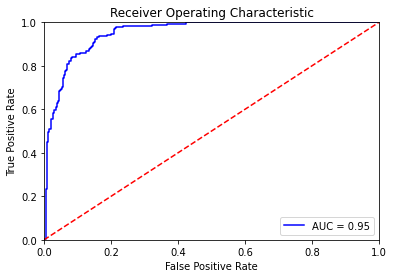

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)
# print(probs)
# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)
# print(probs)
print(len(probs))
# Get predictions from the probabilities
threshold = 0.75
preds = np.where(probs[:, 1] > threshold, 1, 0)
print(preds)
print(len(preds))

# Number of tweets predicted non-negative
print("Number of tweets predicted rumour: ", preds.sum())
# label
# non-rumour    393
# rumour        187

In [ ]:
unique, counts = np.unique(preds, return_counts=True)
dict(zip(unique, counts))

In [ ]:
Corpus_pred_bert = Corpus_dev
print(Corpus_pred_bert.head())
# y_predicted = nb_model.predict(X_test_tfidf)
y_predicted_labels_bert = le.inverse_transform(preds) 
# print(y_predicted,y_predicted_labels)
Corpus_pred_bert['label'] = y_predicted_labels_bert
print(Corpus_pred_bert.head())
# Corpus_pred_bert.set_index('id',inplace=True)
dictt_bert = Corpus_pred_bert.to_dict()['label']
print(dictt_bert)
print(len(dictt_bert))

In [ ]:
with open("dev.baseline_bert2.json", "w") as outfile: 
    json.dump(dictt_bert, outfile)

In [ ]:
print(val_data)
print(X_val)

In [ ]:
print(dfs_dev)
print(Corpus_dev)

In [ ]:
output = Corpus_dev[preds==1]
print(len(output)) #117 tweets detected as rumour in val dataset(source tweets only)
# print(output)

list(output.sample(20).tweet)
lst = list(output.tweet)
print(len(lst))

### 3.5. Train Our Model on the Entire Training Data

In [ ]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, full_train_dataloader, epochs=2)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.538870   |     -      |     -     |   13.92  
   1    |   40    |   0.464896   |     -      |     -     |   13.18  


KeyboardInterrupt: ignored

## 4. Predictions on Test Set

### 4.1. Data Preparation

Let's revisit out test set shortly.

Before making predictions on the test set, we need to redo processing and encoding steps done on the training data. Fortunately, we have written the `preprocessing_for_bert` function to do that for us.

### 4.2. Predictions

There are about 300 non-negative tweets in our test set. Therefore, we will keep adjusting the decision threshold until we have about 300 non-negative tweets.

The threshold we will use is 0.992, meaning that tweets with a predicted probability greater than 99.2% will be predicted positive. This value is very high compared to the default 0.5 threshold.

After manually examining the test set, I find that the sentiment classification task here is even difficult for human. Therefore, a high threshold will give us safe predictions.

Now we will examine 20 random tweets from our predictions. 17 of them are correct, showing that the BERT Classifier acquires about 0.85 precision rate.

# E - Conclusion

By adding a simple one-hidden-layer neural network classifier on top of BERT and fine-tuning BERT, we can achieve near state-of-the-art performance, which is 10 points better than the baseline method although we only have 3,400 data points.

In addition, although BERT is very large, complicated, and have millions of parameters, we only need to fine-tune it in only 2-4 epochs. That result can be achieved because BERT was trained on the huge amount and already encode a lot of information about our language. An impresive performance achieved in a short amount of time, with a small amount of data has shown why BERT is one of the most powerful NLP models available at the moment. 